In [12]:
import sys
sys.path.append('/app')
from src.climate_learn import LitModule
from src.climate_learn import download_weatherbench
from src.climate_learn import convert_nc2npz
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from src.climate_learn.models.module import DiffusionLitModule, LitModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch

In [13]:
in_vars = out_vars = [
    "2m_temperature",
    "geopotential_500",
    "temperature_850",
]
dm = IterDataModule(
    task="downscaling",
    inp_root_dir="/app/data/ClimateLearn/processed/ERA5/5.625",
    out_root_dir="/app/data/ClimateLearn/processed/ERA5/2.8125",
    in_vars=in_vars,
    out_vars=out_vars,
    subsample=1,
    batch_size=16,
    num_workers=4,
)
dm.setup()

diffusion = load_downscaling_module(data_module=dm, architecture="diffusion",
    upsampling="none",
    optim_kwargs={"lr": 5e-4},
    sched="linear-warmup-cosine-annealing",
    sched_kwargs={"warmup_epochs": 5, "max_epochs": 50},
    train_loss="mse",
    val_loss=["rmse", "pearson", "mean_bias", "mse"],
    test_loss=["rmse", "pearson", "mean_bias", "mse"],
    train_target_transform=None,
    val_target_transform=["denormalize", "denormalize", "denormalize", None],
    test_target_transform=["denormalize", "denormalize", "denormalize", None],)

model = DiffusionLitModule.load_from_checkpoint(
        '/app/data/ClimateLearn/experiments/downscaling-ERA5-ERA5/diff_downscaling_era5_era5_initial_run/checkpoints/epoch_011.ckpt',
        net=diffusion.net,
        optimizer=diffusion.optimizer,
        lr_scheduler=diffusion.lr_scheduler,
        train_loss=diffusion.train_loss,
        val_loss=diffusion.val_loss,
        test_loss=diffusion.test_loss,
        train_target_transform=diffusion.train_target_transform,
        val_target_transforms=diffusion.val_target_transforms,
        test_target_transforms=diffusion.test_target_transforms,
    )

Loading architecture: diffusion
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test loss: mse
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize
No test transform


sampling loop time step: 100%|██████████| 100/100 [00:00<00:00, 185.79it/s]
0it [00:00, ?it/s]


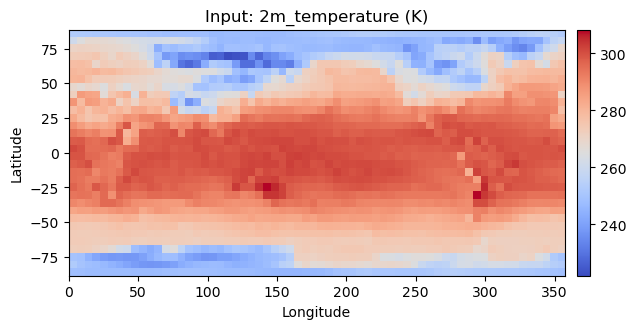

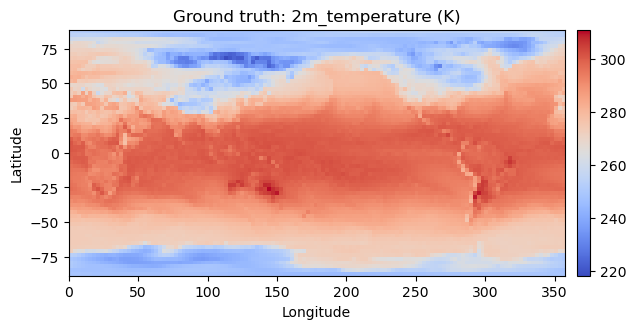

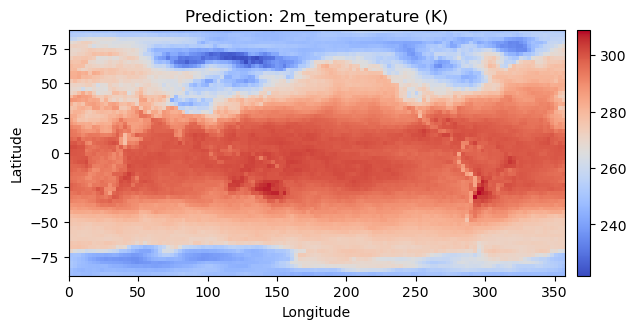

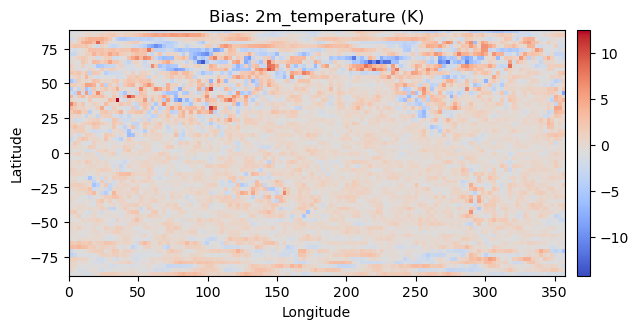

In [14]:
denorm = diffusion.test_target_transforms[0]
in_graphic = visualize_at_index(
    diffusion.to(device="cuda:1"),
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)